In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [8]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [9]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [10]:
train_size = 60000
batch_size = 2560
test_size = 10000

In [11]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(60000).batch(2560))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(10000).batch(2560))

In [12]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=1000, kernel_size=6, strides=(2, 2)),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(
                filters=500, kernel_size=3, strides=(2, 2)),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
            tf.keras.layers.Conv2DTranspose(
                filters=1000, kernel_size=3, strides=(2, 2), padding='same'),
            tf.keras.layers.ReLU(),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=6, strides=(2, 2), padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [13]:
optimizer = tf.keras.optimizers.Nadam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [14]:
epochs = 500
latent_dim = 4
num_examples_to_generate = 25
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [15]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(5, 5))

  for i in range(predictions.shape[0]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [16]:
assert 2560 >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

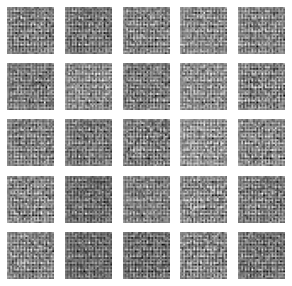

Epoch: 1, Test set ELBO: -406.78497314453125, time elapse for current epoch: 11.663561582565308


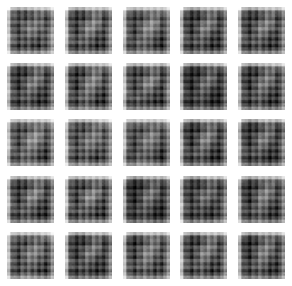

Epoch: 11, Test set ELBO: -194.65264892578125, time elapse for current epoch: 7.952748537063599


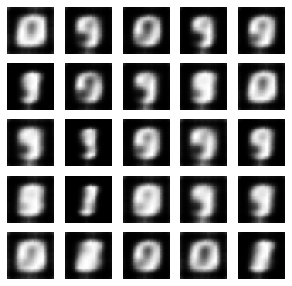

Epoch: 21, Test set ELBO: -159.1893768310547, time elapse for current epoch: 7.955765724182129


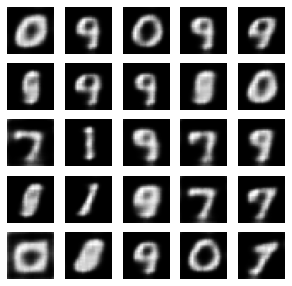

KeyboardInterrupt: ignored

In [17]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  if epoch%10 == 1:
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
          .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)